## Introduction

The 2018 Fantasy Football Auction Draft consisted of 51 various Running Backs drafted by the 10 league members. In this analysis, I focus on how well we drafted with player prices used as the feature of interest. Unfortunately, I was not able to include waiver wire and free agent transactions, trades, and other injuries - this is purely based on the draft. Furthermore, prior to the season's start, LeVeon Bell started his holdout due to contract issues. The league member who drafted LeVeon Bell also drafted his handcuff backup James Conner. Thus, since he didn't lose any points with an easy Bell/Conner switch, I elected to manually change their price points as well.


### Necessary Libraries
We first load the necessary libraries into the environment followed by importing the source data.

In [1]:
library(broom)
library(readxl)
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
#import the raw file provided to you
source <- read_excel("C:/Users/NTellaku/Documents/R/ff/10 Guys 1 Cup/Drafted Players.xlsx",
                     sheet = "2018")
head(source)

Player,Position,Price,Year,Owner
Philip Rivers,QB,2,2018,Naki
Melvin Gordon,RB,52,2018,Naki
Jay Ajayi,RB,22,2018,Naki
Julio Jones,WR,53,2018,Naki
JuJu Smith-Schuster,WR,21,2018,Naki
Michael Crabtree,WR,7,2018,Naki


### Creating the Analytical Data Set

At this point, I manually looked through ESPN's history in order to see the scores of each Running Back. I took these values and manually entered them into a vector. Obviously, there are much more efficient methods to acquire these point totals.

In [3]:
#how much points did each drafted Running Back score in standard scoring in 2018?
rbs_points <- c(225, 38, 160, 129, 173, 203, 93, 152, 121, 88, 49, 87, 196, 8,
                35, 130, 135, 279, 199, 63, 107, 181, 313, 184, 119, 60, 251,
                272, 101, 58, 294, 87, 101, 168, 59, 97, 111, 0, 84, 132, 159,
                147, 164, 58, 109, 144, 0, 92, 161, 75, 224)

rbs <- source %>% 
  filter(Position == "RB") %>% 
  select(Owner, Player, Price) %>% 
  mutate(Points = rbs_points) %>% 
  arrange(Price)

#flipping the values for Conner and Bell
rbs[17, 4] <- 0
rbs[50, 4] <- 224

head(rbs)

Owner,Player,Price,Points
Naki,Marlon Mack,1,160
Naki,Austin Ekeler,1,129
Naki,Nick Chubb,1,173
Mount,Peyton Barber,1,130
Mount,Matt Breida,1,135
Babcock,Kerryon Johnson,1,107


The <code>rbs</code> data set contains the player drafted, league member who drafted them, the price, and the points scored over the course of the season. It does ***not*** cover who ended up with the player (for example trades), adds/drops, and other transactions that would affect roster status.

### Visualization

With the data set ready, we use it to graph a scatterplot of points vs. price, with a predictor function overlaid.

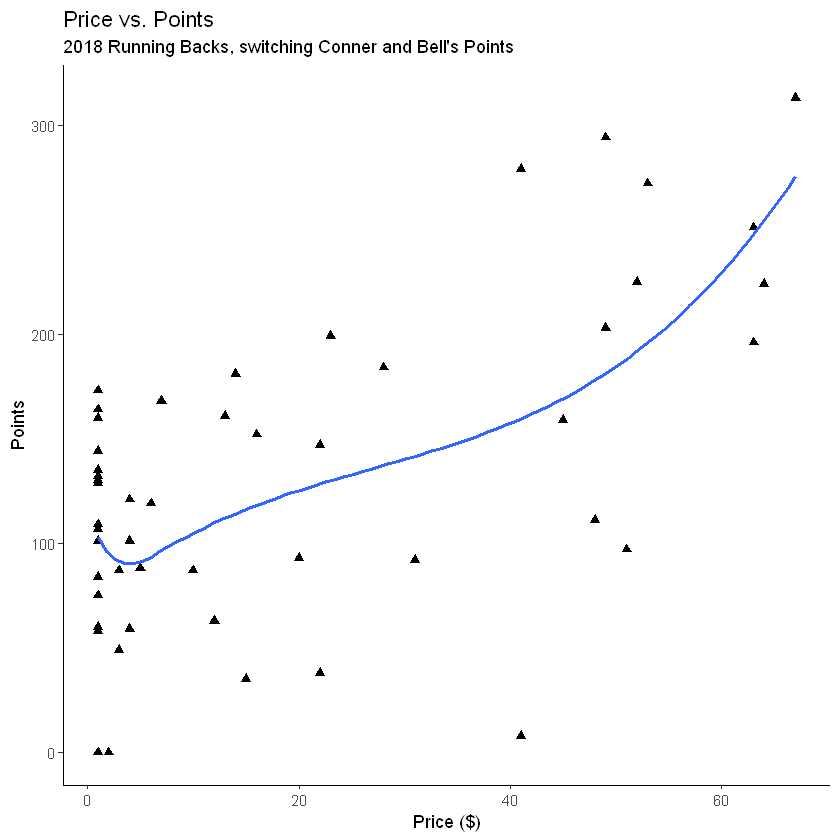

In [4]:
ggplot(rbs, aes(x = Price, y = Points)) +
  geom_point(size = 2, shape = 17) +
  theme_classic() +
  labs(title = "Price vs. Points",
       subtitle = "2018 Running Backs, switching Conner and Bell's Points",
       x = "Price ($)") +
  geom_smooth(method = "lm",
              formula = y ~ splines::bs(x, 4),
              se = F)

Another scatterplot is produced, this time with the drafter highlighted.

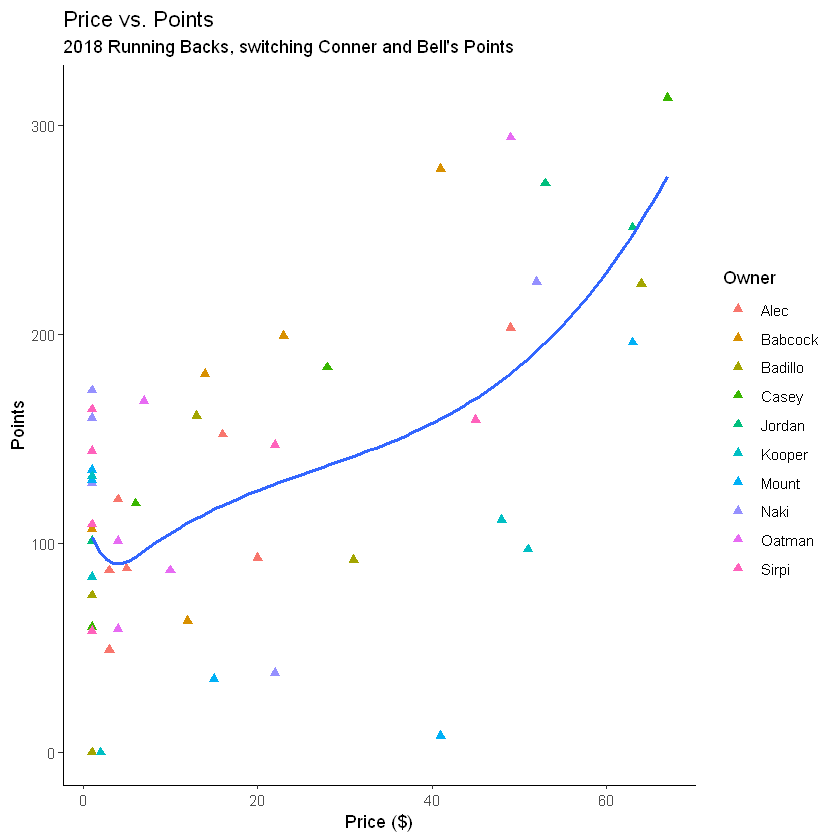

In [5]:
ggplot(rbs, aes(x = Price, y = Points)) +
  geom_point(size = 2, shape = 17, aes(color = Owner)) +
  theme_classic() +
  labs(title = "Price vs. Points",
       subtitle = "2018 Running Backs, switching Conner and Bell's Points",
       x = "Price ($)") +
  geom_smooth(method = "lm",
              formula = y ~ splines::bs(x, 4),
              se = F)

Reminder, James Conner and LeVeon Bell's point totals were switched manually since they were drafted by the same league member.

The scatterplot will be heavily skewed. Proven players and "studs" will be auctioned off for higher values. Fliers, bench filler, and sleeper players will be auctioned for a dollar. Therefore, ordinary least-square regression won't quite work - there is a huge range of point totals at $1.
As a result, I elected to use a polynomial B-spline. This will take into consideration other valleys and peaks in point totals and reveal more information than a straight line. For example, single dollar players drafted may have many purposes, as I listed above. However, a 5 dolalr player is probably more pidgeon-holed to a bench role rather than a useful handcuff that a dollar player would be. Using a piecewise polynomial fitter, the number of knots, or pieceso of the polynomial function, can be more easily defined. An important note is that a B-spline function is differentiable and continuous along its domain.

### Analysis

With the function overlaid, we can indeed see that as a player costs more money, the higher odds the player scores more during the season. Unfortunately, there is a lot of variance with resulting scores leading to immense residuals. For the purposes of this analysis, I elect to grade the best draft by those who had the lowest summed residual.


Here's the table of how each player performed against their expected value according to the spline:

In [6]:
#create the model separately
model <- lm(Points ~ splines::bs(Price, 4), data = rbs)

#add predicted values from model to original data set
rb_table <- augment(model, rbs) %>% 
  mutate(Expected = round(Points - .resid)) %>% 
  mutate(Residual = round(.resid)) %>% 
  select(Owner, Player, Price, Expected, Points, Residual) %>% 
  rename("Actual Points" = Points,
         "Expected Points" = Expected)

rb_table

Owner,Player,Price,Expected Points,Actual Points,Residual
Naki,Marlon Mack,1,103,160,57
Naki,Austin Ekeler,1,103,129,26
Naki,Nick Chubb,1,103,173,70
Mount,Peyton Barber,1,103,130,27
Mount,Matt Breida,1,103,135,32
Babcock,Kerryon Johnson,1,103,107,4
Casey,Rashaad Penny,1,103,60,-43
Jordan,Doug Martin,1,103,101,-2
Jordan,Buck Allen,1,103,58,-45
Kooper,Duke Johnson,1,103,84,-19


Now the summarized-by-drafter for residuals:

In [7]:
total_residual <- rb_table %>%
  group_by(Owner) %>%
  summarize("Total Residual" = sum(Residual)) %>% 
  arrange(`Total Residual`)

total_residual

Owner,Total Residual
Kooper,-243
Mount,-225
Badillo,-162
Alec,6
Jordan,32
Casey,67
Sirpi,72
Naki,96
Oatman,147
Babcock,213


A higher, more positive residual means players scored more than expected and the drafted benefitted from a better value. Grading the draft purely from a running backs perspective Babcock had the best draft. What this table doesn't reveal, is how those RBs were used in terms of transactions, started in the lineup, injuries and replacements, etc.

What we can draw from this table is that generally, more money = more points for the season (obviously). The graphic shows that almost no points lie close to the predictor line. Drafting middle-of-the-pack players may be a risky move - as those players have a much larger variability. Play it safe, go for the proven studs, or take the risks and take the cheap fliers.